In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2
np.random.seed(1)

# Introduction to Convolutions

## 1. Image, Padding, Kernel, Stride, Dot Product

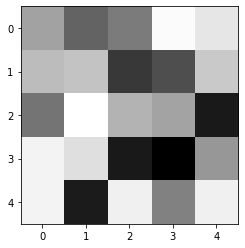

In [2]:
np.random.seed(1)
N,N_H,N_W,n_C=1,5,5,1
X = (np.random.randn(N, N_H,N_W,n_C) * 255).astype(np.uint8)
plt.imshow(X[0,:,:,:], interpolation='none')
plt.show()

### 1.1 Selecting Special Location and Zero Padding

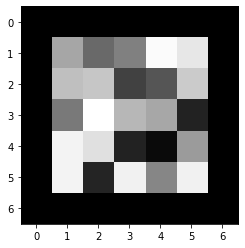

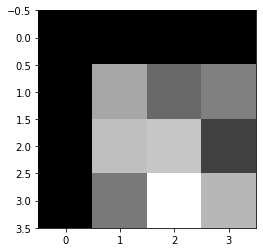

In [3]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. 
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), 'constant', constant_values = 0)    
    return X_pad

def select(X,ith_slice,rec_shape=None):
    """
    Select rectange 
    Argument:
    X -- 
    ith_slice --
    rec_shape --
    Returns:
    X_select -- 
    """ 
    # rec_shape denote a rectangle shape.
    # a--c
    # b--d
    if rec_shape:
        a,b,c,d=rec_shape
        return X[ith_slice,a:b,c:d,:]
    else:
        _,b,d,_=X.shape
        return X[ith_slice,0:b,0:d,:]
        
def show_slice(x):
    plt.imshow(x, interpolation='none')
    plt.show()
    
X_padded=zero_pad(X,1)
show_slice(select(X_padded,0))
show_slice(select(X_padded,0,rec_shape=(0,4,0,4)))

### 1.2 Kernels/ Filters

In [4]:
# Create a filter/kernel has the same size of the image.
w_H,w_W=3,3
W0 = np.random.randn(w_H,w_W)
x=select(X_padded,0)[:,:,0]
x.astype(float)

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 158., 101., 122., 239., 220.,   0.],
       [  0., 182., 188.,  62.,  81., 193.,   0.],
       [  0., 116., 243., 174., 159.,  33.,   0.],
       [  0., 232., 213.,  33.,  10., 148.,   0.],
       [  0., 232.,  35., 229., 128., 229.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.]])

# 2. Convolution Operation

In [5]:
def convolve_step(x,w,b,S):
    """ convolve (slide) over all spatial location."""    
    xD, xH, xW = x.shape
    wD, wH, wW = w.shape
    assert xH==xW and wH== wW and xD==wD
    assert (xW-wW) % S ==0
    num_conv_opt=int((xW-wW)/S+1)
    Z = np.zeros((num_conv_opt, num_conv_opt))
    F=wH
    for i in range(num_conv_opt): # vertical
        for j in range(num_conv_opt): #horiz
        
            x_loc = x[:, #depth.
                      S * i: (S * i) + F,
                      S * j: (S * j) + F]
            Z[i,j]=np.sum(x_loc*w)+ b
    return Z

def convolve(X, W, b, S, pad=0):
    # parameter check
    xN, xD, xH, xW = X.shape
    wN, wD, wH, wW = W.shape
    assert wH == wW
    assert (xH - wH) % S == 0
    assert (xW - wW) % S == 0
    
    zH, zW = (xH - wH) // S + 1, (xW - wW) // S + 1

    zD,zN = wN,xN
    Z = np.zeros((zN, zD, zH, zW))

    for n in range(zN):
        x=X[n]
        for d in range(zD):
            # convolve d.th kernel on n.th input with S.
            Z[n,d,:,:]=convolve_step(x,W[d],b[d],S)
            
    cache = (X, W, b, S)
    return Z,cache


In [6]:
def convolve_forward_step(x,W,b,S):
    """ 
    x.shape = xD, xH, xW
    W.shape = wN,wD, wH, wW
    
    convolve (slide) over all spatial location."""    
    xD, xH, xW = x.shape
    wN,wD, wH, wW = W.shape
    assert (xW-wW) % S ==0
    num_conv_opt=int((xW-wW)/S+1)
    Z = np.zeros((wN,num_conv_opt, num_conv_opt))
    F=wH
    
    for d in range(wN): # .th kernel
        for i in range(num_conv_opt): # vertical
            for j in range(num_conv_opt): #horiz
        
                x_loc = x[:, #depth.
                          S * i: (S * i) + F,
                          S * j: (S * j) + F]
                Z[d,i,j]=np.sum(x_loc*W[d])+ b[d]
    return Z

def convolve_forward(X, W, b, S, pad=0):
    # parameter check
    xN, xD, xH, xW = X.shape
    wN, wD, wH, wW = W.shape
    assert wH == wW
    assert (xH - wH) % S == 0
    assert (xW - wW) % S == 0
    
    zH, zW = (xH - wH) // S + 1, (xW - wW) // S + 1

    zD,zN = wN,xN
    Z = np.zeros((zN, zD, zH, zW))
    dZ = np.zeros((zN, zD, zH, zW))

    for n in range(zN):
        Z[n,:,:,:]=convolve_forward_step(X[n],W,b,S)
    cache = (X, W, b, S)
    return Z,cache

# Convolution with Pytorch

In [7]:
xN, xD, xH, xW =1, 3, 7, 7
X = np.random.randn(xN, xD, xH, xW)
#kernel init
nW, k, s = 1, 3, 2
conv = nn.Conv1d(in_channels=xD, out_channels=nW,kernel_size=(k, k), stride=s)

x_torch = torch.from_numpy(X)
x_torch = x_torch.float()
res=conv(x_torch)
print(res)

tensor([[[[ 0.3669,  0.3132,  1.0201],
          [ 0.0223, -0.7450, -0.3775],
          [ 0.9611,  0.1796,  0.1493]]]], grad_fn=<MkldnnConvolutionBackward>)


# Convolution with Numpy

In [8]:
W=conv.weight.data.detach().numpy()
b=conv.bias.data.detach().numpy()

Z,cache=convolve_forward(X, W, b, s)
print(Z)

[[[[ 0.36690428  0.31318232  1.02012504]
   [ 0.02232347 -0.74501389 -0.37748065]
   [ 0.96114047  0.17957789  0.14925982]]]]


In [9]:
def convolve_backward_step(x,dz,W,b,S):
    
    dzD, dzH, dzW = dz.shape

    xD, xH, xW = x.shape
    wN,wD, wH, wW = W.shape
    
    assert dzD==wN
    assert (xW-wW) % S ==0
    num_conv_opt=int((xW-wW)/S+1)
    F=wH
    dx = np.zeros((xD, xH, xW))
    dW = np.zeros((wN, wD, wH, wW))
    db = np.zeros(wN)
    
    for n in range(wN): # .th kernel
        for i in range(num_conv_opt): # vertical
            for j in range(num_conv_opt): #horiz
        
                x_loc = x[:, #depth.
                          S * i: (S * i) + F,
                          S * j: (S * j) + F]
                dx[:,S * i: (S * i) + F,S * j: (S * j) + F]=W[n]*dz[n] # dz ignored.

                dW[n] = x_loc*dz[n]
                db[n] = np.sum(dz[n])
                    
                return dx,dW,db
    

def convolve_backward(dZ,cache):
    # parameter check
    dZN, dZD, dZH, dZW = dZ.shape
    X, W, b, S = cache
    xN, xD, xH, xW = X.shape
    wN, wD, wH, wW = W.shape

    assert wH == wW and wN == dZD
    assert (xH - wH) % S == 0
    assert (xW - wW) % S == 0
    
    zH, zW = (xH - wH) // S + 1, (xW - wW) // S + 1

    zD,zN = wN,xN
    
    dX = np.zeros((xN, xD, xH, xW))
    dW = np.zeros((xN,wN, wD, wH, wW)) # 
    db = np.zeros(xN)
    for n in range(zN):
        
        dX[n],dW[n],db[n]=convolve_backward_step(X[n],dZ[n],W,b,S)
        
        #print(dx.shape)
        #print(dW.shape)
    


convolve_backward(Z,cache)

In [10]:
np.random.seed(1)

xN, xD, xH, xW =2, 3, 7, 7
X = np.random.randn(xN, xD, xH, xW)
#kernel init
nW, k, s = 2, 1, 2
conv = nn.Conv1d(in_channels=xD, out_channels=nW,kernel_size=(k, k), stride=s)
x_torch = torch.from_numpy(X)
x_torch = x_torch.float()
res=conv(x_torch)
W=conv.weight.data.detach().numpy()
b=conv.bias.data.detach().numpy()
Z,cache=convolve(X, W, b, s)

# Backprogataion Conv

In [11]:
def conv_forward(X, W):
    '''
    The forward computation for a convolution function
    
    Arguments:
    X -- output activations of the previous layer, numpy array of shape (n_H_prev, n_W_prev) assuming input channels = 1
    W -- Weights, numpy array of size (f, f) assuming number of filters = 1
    
    Returns:
    H -- conv output, numpy array of size (n_H, n_W)
    cache -- cache of values needed for conv_backward() function
    '''
    
    # Retrieving dimensions from X's shape
    (n_H_prev, n_W_prev) = X.shape
    
    # Retrieving dimensions from W's shape
    (f, f) = W.shape
    
    # Compute the output dimensions assuming no padding and stride = 1
    n_H = n_H_prev - f + 1
    n_W = n_W_prev - f + 1
    
    # Initialize the output H with zeros
    H = np.zeros((n_H, n_W))
    
    # Looping over vertical(h) and horizontal(w) axis of output volume
    for h in range(n_H):
        for w in range(n_W):
            x_slice = X[h:h+f, w:w+f]
            H[h,w] = np.sum(x_slice * W)
            
    # Saving information in 'cache' for backprop
    cache = (X, W)
    
    return H, cache


def conv_backward(dH, cache):
    '''
    The backward computation for a convolution function
    
    Arguments:
    dH -- gradient of the cost with respect to output of the conv layer (H), numpy array of shape (n_H, n_W) assuming channels = 1
    cache -- cache of values needed for the conv_backward(), output of conv_forward()
    
    Returns:
    dX -- gradient of the cost with respect to input of the conv layer (X), numpy array of shape (n_H_prev, n_W_prev) assuming channels = 1
    dW -- gradient of the cost with respect to the weights of the conv layer (W), numpy array of shape (f,f) assuming single filter
    '''
    
    # Retrieving information from the "cache"
    (X, W) = cache
    
    # Retrieving dimensions from X's shape
    (n_H_prev, n_W_prev) = X.shape
    
    # Retrieving dimensions from W's shape
    (f, f) = W.shape
    
    # Retrieving dimensions from dH's shape
    (n_H, n_W) = dH.shape
    
    # Initializing dX, dW with the correct shapes
    dX = np.zeros(X.shape)
    dW = np.zeros(W.shape)
    
    # Looping over vertical(h) and horizontal(w) axis of the output
    for h in range(n_H):
        for w in range(n_W):
            dX[h:h+f, w:w+f] += W * dH(h,w)
            dW += X[h:h+f, w:w+f] * dH(h,w)
    
    return dX, dW

# Pooling

In [12]:
# pool


xN, xD, xH, xW =2, 3, 7, 7
X = np.random.randn(xN, xD, xH, xW)
#kernel init
nW, k, s = 2, 1, 2
conv = nn.Conv1d(in_channels=xD, out_channels=nW,kernel_size=(k, k), stride=s)

x_torch = torch.from_numpy(X)
x_torch = x_torch.float()
res=conv(x_torch)
print(res)
print(res.shape)

tensor([[[[ 0.5510, -0.0690,  0.1572, -1.1135],
          [-0.7062, -0.2047,  0.2572, -0.0537],
          [ 0.0431, -0.1442,  1.9533,  0.0230],
          [ 1.8321,  1.7977,  0.7392,  1.8597]],

         [[ 0.5237,  0.5749,  0.2272,  0.3974],
          [ 0.6568,  0.3183,  1.1487,  1.1175],
          [ 0.2561,  0.3824,  0.2088,  0.0113],
          [-0.3637, -0.4128, -0.0566,  0.9529]]],


        [[[ 1.4037, -0.6299, -0.1272, -0.3270],
          [ 0.2388,  0.2696,  1.0443,  2.0536],
          [ 0.9007,  1.3874, -0.0511,  1.9850],
          [-0.1807,  0.0550,  0.0670, -0.3091]],

         [[-0.1590,  0.6069, -0.3165,  1.0168],
          [ 0.1648,  0.2015, -0.1999,  0.7849],
          [ 0.2939,  0.9357,  0.8330,  0.4595],
          [ 0.4909,  0.3967,  1.0961, -0.5626]]]],
       grad_fn=<MkldnnConvolutionBackward>)
torch.Size([2, 2, 4, 4])


In [13]:

def max_pool(x,F,S):
    """ convolve (slide) over all spatial location."""    
    xD, xH, xW = x.shape
    assert (xW-F) % S ==0
    num_opt=int((xW-F)/S+1)
    Z = np.zeros((xD,num_opt, num_opt))
    for i in range(num_opt): # vertical
        for j in range(num_opt): #horiz
            for d in range(xD):            
                Z[d,i,j] = x[d, # depth
                          S * i: (S * i) + F,
                          S * j: (S * j) + F].max()
    return Z

def pooling(X, k, S):
    # parameter check
    xN, xD, xH, xW = X.shape
    assert (xH - k) % S == 0
    assert (xW - k) % S == 0
    
    zH, zW = (xH - k) // S + 1, (xW - k) // S + 1
    zN,zD=xN,xD
    Z = np.zeros((zN, zD, zH, zW))

    for n in range(zN):
        x=X[n]
        Z[n,:,:,:]=max_pool(x,k,S)
        
    return Z

v=res.data.detach()
m = nn.MaxPool2d(2, stride=s)

print(m(v))

pooling(v.numpy(),2,s)


tensor([[[[0.5510, 0.2572],
          [1.8321, 1.9533]],

         [[0.6568, 1.1487],
          [0.3824, 0.9529]]],


        [[[1.4037, 2.0536],
          [1.3874, 1.9850]],

         [[0.6069, 1.0168],
          [0.9357, 1.0961]]]])


array([[[[0.55101329, 0.25721157],
         [1.83209276, 1.95325613]],

        [[0.65677232, 1.14872611],
         [0.38240495, 0.95293182]]],


       [[[1.40366983, 2.05356979],
         [1.38743043, 1.98496807]],

        [[0.60688061, 1.01683474],
         [0.93565553, 1.09606278]]]])

In [14]:

def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """

    ### START CODE HERE ### (≈ 2 lines of code)
    # Element-wise product between a_slice_prev and W. Do not add the bias yet.
    s = np.multiply(a_slice_prev, W)
    # Sum over all entries of the volume s.
    Z = np.sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z += float(b)
    ### END CODE HERE ###

    return Z

def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from A_prev's shape (≈1 line)  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters" (≈2 lines)
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Compute the dimensions of the CONV output volume using the formula given above. Hint: use int() to floor. (≈2 lines)
    n_H = int((n_H_prev - f + 2 * pad)/stride) + 1
    n_W = int((n_W_prev - f + 2 * pad)/stride) + 1
    
    # Initialize the output volume Z with zeros. (≈1 line)
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                                  # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]                      # Select ith training example's padded activation
        for h in range(n_H):                            # loop over vertical axis of the output volume
            for w in range(n_W):                        # loop over horizontal axis of the output volume
                for c in range(n_C):                    # loop over channels (= #filters) of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h * stride
                    vert_end = vert_start + f 
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈1 line)
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[...,c], b[...,c])
                                        
    ### END CODE HERE ###
    
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache



def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function
    
    Arguments:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward(), output of conv_forward()
    
    Returns:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """
    
    ### START CODE HERE ###
    # Retrieve information from "cache"
    (A_prev, W, b, hparameters) = cache
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                           
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                          # loop over the training examples
        
        # select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_H):                   # loop over vertical axis of the output volume
            for w in range(n_W):               # loop over horizontal axis of the output volume
                for c in range(n_C):           # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice"
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:, :, :, c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, w, h, c]
                    
        # Set the ith training example's dA_prev to the unpaded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    ### END CODE HERE ###
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    ### START CODE HERE ###
    for i in range(m):                           # loop over the training examples
        for h in range(n_H):                     # loop on the vertical axis of the output volume
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    # Compute the pooling operation on the slice. Use an if statment to differentiate the modes. Use np.max/np.mean.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    ### END CODE HERE ###
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache



def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    
    Arguments:
    x -- Array of shape (f, f)
    
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """
    
    ### START CODE HERE ### (≈1 line)
    mask = np.max(x) == x
    ### END CODE HERE ###
    
    return mask



def distribute_value(dz, shape):
    """
    Distributes the input value in the matrix of dimension shape
    
    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from shape (≈1 line)
    (n_H, n_W) = shape
    
    # Compute the value to distribute on the matrix (≈1 line)
    average = dz / (n_H * n_W)

    # Create a matrix where every entry is the "average" value (≈1 line)
    a = np.ones(shape) * average
    ### END CODE HERE ###
    
    return a

def pool_backward(dA, cache, mode = "max"):
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
    dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
    cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
    """
    
    ### START CODE HERE ###
    
    # Retrieve information from cache (≈1 line)
    (A_prev, hparameters) = cache
    
    # Retrieve hyperparameters from "hparameters" (≈2 lines)
    stride = hparameters['stride']
    f = hparameters['f']
    
    # Retrieve dimensions from A_prev's shape and dA's shape (≈2 lines)
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # Initialize dA_prev with zeros (≈1 line)
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    
    for i in range(m):                          # loop over the training examples
        
        # select training example from A_prev (≈1 line)
        a_prev = A_prev[i]
        
        for h in range(n_H):                   # loop on the vertical axis
            for w in range(n_W):               # loop on the horizontal axis
                for c in range(n_C):           # loop over the channels (depth)
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Compute the backward propagation in both modes.
                    if mode == "max":
                        
                        # Use the corners and "c" to define the current slice from a_prev (≈1 line)
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        # Create the mask from a_prev_slice (≈1 line)
                        mask = create_mask_from_window(a_prev_slice)
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA) (≈1 line)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += np.multiply(mask, dA[i, h, w, c]) 
                        
                    elif mode == "average":
                        
                        # Get the value a from dA (≈1 line)
                        da = dA[i, h, w, c]
                        # Define the shape of the filter as fxf (≈1 line)
                        shape = (f, f)
                        # Distribute it to get the correct slice of dA_prev. i.e. Add the distributed value of da. (≈1 line)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)
                        
    ### END CODE ###
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [15]:
np.random.seed(1)

A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,"stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

#print("Z's mean =", np.mean(Z))
#print("Z[3,2,1] =", Z[3,2,1])
#print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])


#A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 2, "f": 3}
A, cache = pool_forward(A_prev, hparameters)
#print("mode = max")
#print("A =", A)
#print()
#A, cache = pool_forward(A_prev, hparameters, mode = "average")
#print("mode = average")
#print("A =", A)




dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))





#x = np.random.randn(2,3)
#mask = create_mask_from_window(x)
#print('x = ', x)
#print("mask = ", mask)

#a = distribute_value(2, (2,2))
#print('distributed value =', a)

dA_mean = 1.4524377775388075
dW_mean = 1.7269914583139097
db_mean = 7.839232564616852


In [16]:

np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
